## Question 6

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=np.inf)

### Optimization Problem

In this problem, we maximize the diversification ratio for a long-only portfolio. The constraints are clearly convex and the objective function is quasiconcave. This can be seen by considering the superlevel sets of the diversification ratio function. They are given by <br>
$S_{\alpha}=\left\{x \mid \sigma^{T} x /\left\|\Sigma^{1 / 2} x\right\|_{2} \geq \alpha\right\}$ where $\left\|\Sigma^{1 / 2} x\right\|_{2} = (x^T \Sigma x)^{\frac{1}{2}}$ <br> <br>
Use the remark to see that $D(x) \geq 1$ for long-only portfolios. So we focus on $\alpha \geq 1$. <br>
The $\alpha$-superlevel set is defined by
$\frac{\sigma^{T} x}{\left\|\Sigma^{1 / 2} x\right\|_{2}} \geq \alpha \Longleftrightarrow \sigma^{T} x \geq \alpha\left\|\Sigma^{1 / 2} x\right\|_{2}$ <br>
For positive $\alpha$, this is a second-order cone constraint and hence convex. Hence $D(x)$ is quasiconcave. So the problem of maximizing $D(x)$ given the constraints is a quasiconvex optimization problem.

### Quasiconvex to Convex

We notice that $D(tx) = D(x)$ for $t>0$ to convert the quasiconvex optimization problem to a convex optimization problem. We need homogeneity in our constraints to perform a variable transformation by scaling. The constraint $x \geq 0$ is homogeneous already. For the constraint $x \leq M$, we rewrite it as $x \leq M\mathbf{1}^Tx$. So the problem is now <br>
max. $\sigma^{T} x /\left\|\Sigma^{1 / 2} x\right\|_{2}$ <br>
s.t. $x \leq M\mathbf{1}^Tx, \mathbf{1}^{T} x=1, x \geq 0$ <br> <br>
For homogeneity in the constraint $\mathbf{1}^{T} x=1$, we perform a change of variable $z=x / \sigma^{T} x$. (This is a positive multiple of $x$.) The variable $z$ satisfies $\sigma^{T} z=1$; we can recover $x$ from $z$ as $x=z / \mathbf{1}^{T} z$ (since $\mathbf{1}^{T} z = 1/\mathbf{\sigma}^{T} x$). Using $z$ the problem becomes <br>
$\operatorname{max.}  1 /\left\|\Sigma^{1 / 2} z\right\|_{2}$ <br>
s.t. $z \leq M\mathbf{1}^Tz, \quad \mu^{T} z=1, z \geq 0$ <br> <br>
The reciprocal of the objective function is simply the norm of an affine function and hence convex. Therefore this is a convex optimization problem written as <br><br>
$\operatorname{min.}  \left\|\Sigma^{1 / 2} z\right\|_{2}$ <br>
s.t. $z \leq M\mathbf{1}^Tz, \quad \mu^{T} z=1, z \geq 0$ 

### Implementation

In [3]:
# problem data

rng = np.random.Generator(np.random.MT19937(seed=12345))
n = 20
# _A and _C are internal - you don't need them.
_A = rng.standard_normal((2*n, n))
_C = np.diag(0.5*np.exp(rng.standard_normal((n,))))

Sigma = _C@_A.T@_A@_C
Sigma = 0.5*(Sigma + Sigma.T)
M = np.ones(n)*0.2
sigma = np.sqrt(np.diag(Sigma))

In [4]:
# defining variables

z = cp.Variable(n, pos=True)
root_Sig = sqrtm(Sigma)

In [5]:
# defining constraints

cons = [sigma.T@z == 1]
cons += [z<= M*cp.sum(z)]

In [6]:
# defining objective function

obj = cp.Minimize(cp.norm(root_Sig@z))

In [7]:
# solve the problem

prob = cp.Problem(obj, cons)
prob.solve();

In [8]:
# recovering optimal x* from transformed variable

x = z.value/np.sum(z.value)
print("The optimal portfolio weights are {}".format(x))

The optimal portfolio weights are [0.16 0.01 0.01 0.01 0.   0.03 0.04 0.03 0.05 0.05 0.01 0.02 0.   0.07 0.09 0.04 0.01 0.06 0.11 0.2 ]


In [9]:
# calculating optimal diversification ratio

Dstar = (sigma.T@x)/(np.linalg.norm(root_Sig@x))
print("The optimal diversification ratio is {}".format(Dstar))

The optimal diversification ratio is 8.112058694514948


In [10]:
# solving the minimum variance portfolio problem

x_mv = cp.Variable(n, nonneg=True)
cons_mv = [cp.sum(x_mv) == 1, x_mv <= M]
obj_mv = cp.Minimize(cp.quad_form(x_mv, Sigma))
prob_mv = cp.Problem(obj_mv, cons_mv)
prob_mv.solve();

In [11]:
# calculating diversification ratio for long-only minimum variance portfolio problem

Dmv = (sigma.T@x_mv.value)/(np.linalg.norm(root_Sig@x_mv.value))
print("The diversification ratio of the long-only minimum variance portfolio is {}".format(Dmv))

The diversification ratio of the long-only minimum variance portfolio is 6.518720594571963


As expected, the diversification of the minimum variance portfolio is less than the optimal value for diversification ratio.

We use the given plotting function to plot the bar graphs.

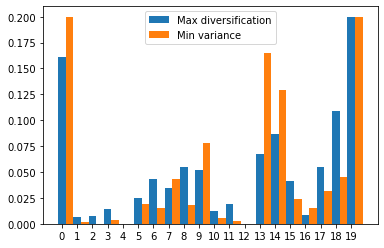

In [12]:
plt.bar(np.arange(0,20), x, width=0.5, label="Max diversification");
plt.bar((np.arange(0,20)*2+1)/2, x_mv.value, width=0.5, label="Min variance");
plt.legend();
plt.xticks(np.arange(0,20));